In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()

,Temperature
YearMonth,
1880-01-01,-0.36
1880-02-01,-0.51
1880-03-01,-0.23
1880-04-01,-0.30
1880-05-01,-0.06


# 1.Neural Network

In [3]:
tst_size = 20


In [4]:
data.head()

,Temperature
YearMonth,
1880-01-01,-0.36
1880-02-01,-0.51
1880-03-01,-0.23
1880-04-01,-0.30
1880-05-01,-0.06


In [5]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx+self.forecast_size]

    return look_back, forecast

In [6]:
from sklearn.preprocessing import MinMaxScaler

lookback_size = 9
forecast_size = 4

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-lookback_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [7]:
x, y = next(iter(trn_dl))

x.shape, y.shape

(torch.Size([32, 9]), torch.Size([32, 4]))

In [8]:
class Net(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    return F.sigmoid(x)

In [9]:
from tqdm.auto import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(9, 4, 512)
net.to(device)

optim = torch.optim.AdamW(net.parameters(), lr=0.0001)

pbar = trange(2000)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    p = net(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = net(x)
    tst_loss = F.mse_loss(p,y)
    # tst_mape = mape(p,y)
    # tst_mae = mae(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})#, 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2000/2000 [02:24<00:00, 13.86it/s, loss=0.00335, tst_loss=0.00113]


In [10]:
net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = net(x)

def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()


def r2_score(y_pred, y_true):
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

In [11]:
res_dict = {}

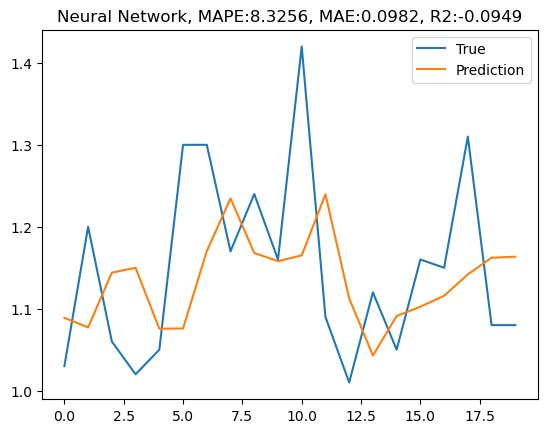

In [12]:
plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

(20, 4)
(20,)
MAPE:  9.246973021410815
MAE:  0.1050904233455658
R2_Score:  -0.09199271282158517


<Axes: xlabel='YearMonth'>

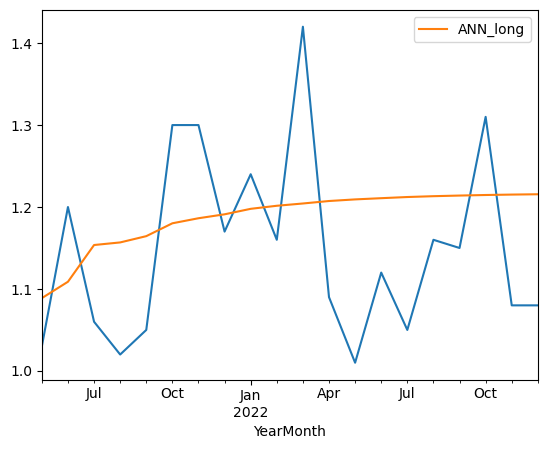

In [13]:
# 장기예측
window_size = 9
prediction_size = 4
test_size=20
preds = []
tst_data  = data [-tst_size :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]

for _ in range(test_size):
  #print(x.shape, y.shape)
  y=y.squeeze()
  #print(x.shape, y.shape)

  x = np.concatenate([x,y])[-window_size:]
  #x = x.flatten()
  #y = y.flatten()
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=net(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
print(preds.shape)
preds = preds[:,0]
print(preds.shape)

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [14]:
torch.save(net.state_dict(), './Adamax_(4,12,6)model.pth')

# 2.Multi-channel

In [15]:
m_data = data.copy()
m_data['rolling_mean'] = data.rolling(12).mean()
m_data['diff'] = data.diff(1)
m_data

,Temperature,rolling_mean,diff
YearMonth,,,
1880-01-01,-0.36,NaN,NaN
1880-02-01,-0.51,NaN,-0.15
1880-03-01,-0.23,NaN,0.28
1880-04-01,-0.30,NaN,-0.07
1880-05-01,-0.06,NaN,0.24
...,...,...,...
2022-08-01,1.16,1.172500,0.11
2022-09-01,1.15,1.180833,-0.01
2022-10-01,1.31,1.181667,0.16


In [16]:
m_data = m_data.dropna()

lookback_size = 24
forecast_size = 4
tst_size = 20

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(m_data[:-tst_size].to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(m_data[-tst_size-lookback_size:].to_numpy(dtype=np.float32))

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [17]:
trn_scaled.shape

(1685, 3)

In [18]:
x, y = next(iter(trn_dl))

In [19]:
x.shape # Batch, Length, Channel

torch.Size([32, 24, 3])

In [20]:
y.shape

torch.Size([32, 4, 3])

In [21]:
class NetMulti(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, c_in, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in*c_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_hidden)
    self.lin3 = nn.Linear(d_hidden, d_out*c_in)
    self.activation = activation
    self.c_in = c_in
    self.d_out = d_out

  def forward(self, x):
    x = x.flatten(1)    # (B, d_in * c_in)
    x = self.lin1(x)    # (B, d_hidden)
    x = self.activation(x)
    for _ in range(2):
      x = self.lin2(x)    # (d_hidden, d_hidden)
      x = self.activation(x)
    x = self.lin3(x).reshape(-1, self.d_out, self.c_in)    # (B, d_out, c_in)
    return F.sigmoid(x)

In [22]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 24, 3]), torch.Size([32, 4, 3]))

In [23]:
x.flatten(1).shape

torch.Size([32, 72])

In [24]:
from tqdm.auto import trange

Multinet = NetMulti(24, 4, 512, 3)
Multinet.to(device)

optim = torch.optim.AdamW(Multinet.parameters(), lr=0.0001)

pbar = trange(2000)
for i in pbar:
  Multinet.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)   # (32, 24, 3), (32, 4, 3)
    p = Multinet(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  Multinet.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = Multinet(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

100%|██████████| 2000/2000 [02:47<00:00, 11.96it/s, loss=6.07e-5, tst_loss=0.0049]  


In [25]:
res_dict = {}

torch.Size([17, 4, 3])
torch.Size([17, 4, 3])
(68, 3)
[[1.0299999 1.1999999 1.0600001 1.02     ]
 [1.1999999 1.0600001 1.02      1.05     ]
 [1.0600001 1.02      1.05      1.3      ]
 [1.02      1.05      1.3       1.3      ]
 [1.05      1.3       1.3       1.17     ]
 [1.3       1.3       1.17      1.2399999]
 [1.3       1.17      1.2399999 1.1600001]
 [1.17      1.2399999 1.1600001 1.4200001]
 [1.2399999 1.1600001 1.4200001 1.0899999]
 [1.1600001 1.4200001 1.0899999 1.0100001]
 [1.4200001 1.0899999 1.0100001 1.1200001]
 [1.0899999 1.0100001 1.1200001 1.05     ]
 [1.0100001 1.1200001 1.05      1.1600001]
 [1.1200001 1.05      1.1600001 1.15     ]
 [1.05      1.1600001 1.15      1.3100001]
 [1.1600001 1.15      1.3100001 1.08     ]
 [1.15      1.3100001 1.08      1.08     ]] [[[ 0.8744479   1.1571945  -0.25725225]
  [ 0.88651335  1.1445564   0.00457762]
  [ 0.8097805   1.1281792  -0.07619538]
  [ 0.8281864   1.110738   -0.01147701]]

 [[ 1.0785723   1.1831262   0.09055502]
  [ 1.090428

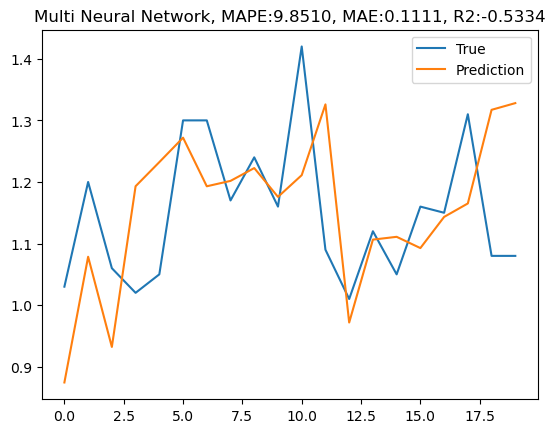

In [31]:
Multinet.eval()
Multinet.to('cuda')
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  print(y.shape) #17,4,3
  y=y.reshape(-1,3)
  y=scaler.inverse_transform(y.cpu().numpy())
  y=y.reshape(17,4,3)
  x, y = x.flatten(1), y[:,:,0] #17,4 #0번째 채널 뽑고 있다


  x = x.to('cuda')
  #p = Multinet(x)[:,:,0]
  p = Multinet(x)
  print(p.shape)
  p = p.reshape(-1,3)
  p=p.cpu()
  p=scaler.inverse_transform(p.numpy())
  print(p.shape)
  p = p.reshape(17,4,3)


print(y,p)
print(y.shape,p.shape)

#y = y.cpu()/scaler.scale_[0] + scaler.min_[0]
#p = p.cpu()/scaler.scale_[0] + scaler.min_[0]

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
#print(y,p)
#print(y.shape,p.shape)
p = p[:,0] #y부분과 동일하게 변경 

#inverse_preds = scaler.inverse_transform(p.reshape(-1,3))


plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y),  'R2':r2_score(p,y)}})

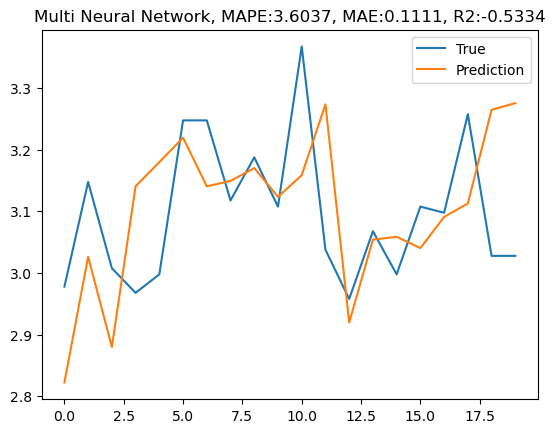

In [26]:
""" Multinet.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.flatten(1).to(device), y[:,:,0].to(device)
  p = Multinet(x)[:,:,0]

y = y.cpu()/scaler.scale_[0] + scaler.min_[0]
p = p.cpu()/scaler.scale_[0] + scaler.min_[0]

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y),  'R2':r2_score(p,y)}}) """

In [27]:
# 장기예측
window_size = 24
prediction_size = 4
test_size=20
preds = []

tst_data = data[-tst_size:]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Multinet.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]
print(y)
print(x.shape , y.shape)
# x = x[:,0]
# y = y[:,0]
# print(x.shape , y.shape)


[[0.8028985  0.96783626 0.49456525]
 [0.71304345 0.93650794 0.30978262]
 [0.7855072  0.9177109  0.6141305 ]
 [0.76231885 0.90601504 0.43478262]]
(24, 3) (4, 3)


(20,)
MAPE:  12.812702460304404
MAE:  0.14918994724750517
R2_Score:  -1.5090255068142961


<Axes: xlabel='YearMonth'>

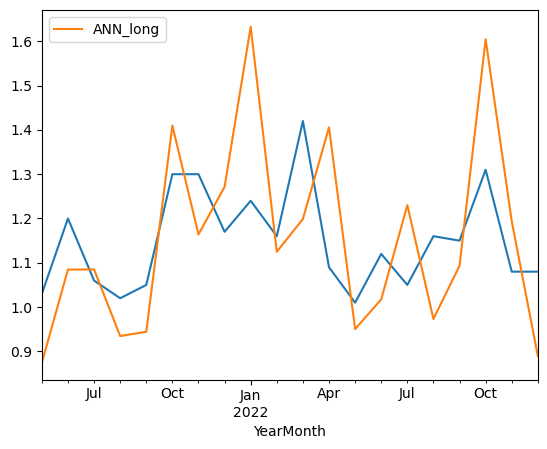

In [28]:
preds = []

for i in range(test_size):
  y = y.squeeze()
  # print(i, x.shape, y.shape)
  x = np.concatenate([x,y])[-window_size:]
    
  x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
  # print(x_tensor.shape)
  y = Multinet(x_tensor)
  # print(y.shape)
  y = y.detach().cpu().numpy()
  # y = y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)
  # print(i, x.shape, y.shape)


preds = np.concatenate(preds, axis=0)
# print(preds.shape)
# expanded_preds = np.zeros((preds.shape[0], 3))  
# expanded_preds[:, 0] = preds[:, 0]  


inverse_preds = scaler.inverse_transform(preds.reshape(-1,3)).reshape(-1,4,3)


final_preds = inverse_preds[:, 0,0]
print(final_preds.shape)
#print(preds.shape)
#y = y/scaler.scale_[0] + scaler.min_[0]
#preds = preds/scaler.scale_[0] + scaler.min_[0]
#preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
#preds = preds[:,0]
#print(preds.shape)

mape2 = mape(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": final_preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [32]:
torch.save(Multinet.state_dict(), './multi3_adamW_0e4_1_hidden512_2_look24.pth')